<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/Data_Analyst_Agent_Cohere_and_Langchain.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tool Use - Simple Data Analyst Agent with Cohere and Langchain

Tool use is a method whichs allows developers to connect Cohere's Command models to external tools like search engines, APIs, databases, and other software tools. Just like how [Retrieval-Augmented Generation (RAG)](https://docs.cohere.com/docs/retrieval-augmented-generation-rag) allows a model to use an external data source to improve factual generation, tool use is a capability that allows retrieving data from multiple sources. But it goes beyond simply retrieving information and is able to use software tools to execute code, or even create entries in a CRM system.

In this notebook, we'll see how we can use two tools to create a simple data analyst agent that is able to search the web and run code in a python interpreter. This agent uses Cohere's Command R+ mode and Langchain.


![](https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/images/tool-use-notebook-header.png)

# Environment
Let's start by installing the required libraries

In [1]:
! pip install --quiet langchain langchain_cohere langchain_experimental

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

## Setup
We'll need a Cohere API key here. Grab your key and paste it in the next slide if you have one, or [register](https://dashboard.cohere.ai/welcome/register) and create a new API key.

In [2]:
### LLMs
import os
os.environ['COHERE_API_KEY'] = <sfef>

In [3]:
# Create the Cohere chat model
from langchain_cohere.chat_models import ChatCohere
chat = ChatCohere(model="command-r-plus", temperature=0.3)

# Define tools
Our simple data analyst will be equipped with a web search tool, and a python interpreter (which we can use to run plotting code, for example).

### Web search
Let's first equip our agent with web search! We can use the Tivaly API for this. Head on to [tavily.com](https://tavily.com) and grab an API key to use here.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ['TAVILY_API_KEY'] = "<>

internet_search = TavilySearchResults()
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."


from langchain_core.pydantic_v1 import BaseModel, Field
class TavilySearchInput(BaseModel):
    query: str = Field(description="Query to search the internet with")
internet_search.args_schema = TavilySearchInput

### Python interpreter tool
Let's equip our agent with a python interpreter!

In [5]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

# from langchain_core.pydantic_v1 import BaseModel, Field
class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
repl_tool.args_schema = ToolInput


# Create ReAct Agent: the data analyst

In [6]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [7]:
# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search, repl_tool],
    prompt=prompt,
)

In [8]:
agent_executor = AgentExecutor(agent=agent, tools=[internet_search, repl_tool], verbose=True)

# Let's ask a question to the data analyst



> Entering new AgentExecutor chain...

First, I will search for the 3 tech companies with the highest market cap in the United States in 2024. Then, I will search for the number of full-time employees at each of these companies. Finally, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'internet_search', 'parameters': {'query': '3 tech companies with highest market cap in the United States 2024'}}
[{'url': 'https://simplywall.st/stocks/us/tech/market-cap-large', 'content': 'United States / Largest U.S. Tech Stocks by Market Cap. UPDATED Apr 25, 2024. Discover large cap U.S. Tech companies that are on the NYSE and NASDAQ. These Tech Companies are organised by Market Cap. 🇺🇸 US Market Tech. Advanced Filters. Market Cap High to Low. 208 companies ...'}, {'url': 'https://www.statista.com/statistics/1350976/leading-tech-companies-worldwide-by-market-cap/', 'content': 'Digital & Trend reports\nOverview and forecasts on trending topic


I found that the number of full-time employees at Apple, Microsoft, and Nvidia as of 2023 are 161,000, 221,000, and 29,600, respectively. Now, I will use Python to create a plot of the number of full-time employees at these companies.
{'tool_name': 'python_interpreter', 'parameters': {'code': 'import matplotlib.pyplot as plt\n\n# Number of full-time employees at the 3 tech companies\nnum_employees = [161000, 221000, 29600]\ncompanies = ["Apple", "Microsoft", "Nvidia"]\n\n# Create a bar plot\nplt.bar(companies, num_employees)\n\n# Add labels and title\nplt.xlabel("Company")\nplt.ylabel("Number of Full-Time Employees")\nplt.title("Number of Full-Time Employees at the Top 3 Tech Companies in the US")\n\n# Save the plot\nplt.savefig("number_of_full_time_employees.png")'}}
Relevant Documents: 2,3,4,7,9,10,11,13,14,17,18,20
Cited Documents: 2,3,4,7,9,10,11,13,14,17,18,20
Answer: Here is a plot showing the number of full-time employees at the 3 tech companies with the highest market cap in t

{'input': 'Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.',
 'output': 'Here is a plot showing the number of full-time employees at the 3 tech companies with the highest market cap in the United States in 2024:\n\n! [Number of Full-Time Employees](number_of_full_time_employees.png)\n\nThe number of full-time employees at Apple, Microsoft, and Nvidia as of 2023 are 161,000, 221,000, and 29,600, respectively.',
 'citations': [CohereCitation(start=140, end=208, text='! [Number of Full-Time Employees](number_of_full_time_employees.png)', documents=[{'output': '', 'id': 'doc_20'}], document_ids={'doc_20'}),
  CohereCitation(start=247, end=252, text='Apple', documents=[{'url': 'https://www.macrotrends.net/stocks/charts/AAPL/apple/number-of-employees', 'content': 'Employee Count. Interactive chart of Apple (AAPL) annual worldwide employee count from 2010 to 2023. Apple total number of employees in 2023 was 1

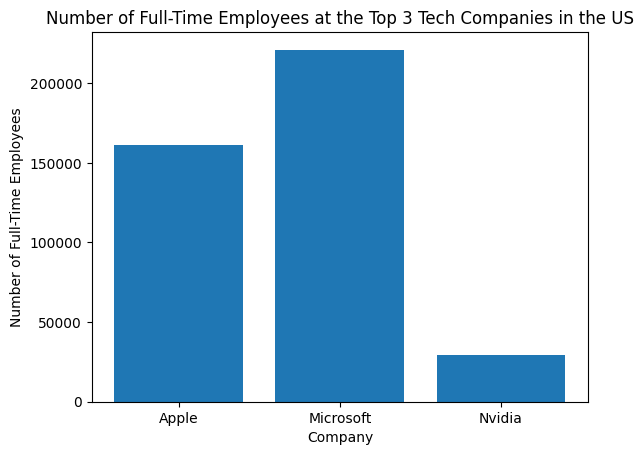

In [9]:
agent_executor.invoke({
    "input": "Create a plot of the number of full time employees at the 3 tech companies with the highest market cap in the United States in 2024.",
})

In [ ]:
# notice that the model did websearch calls, then used python to do some analysis
# the model can even self-debug itself if the python code was wrong

# Let's ask another question to the data analyst -- which requires a direct answer

In [ ]:
agent_executor.invoke({
    "input": "Hey how are you?",
})



> Entering new AgentExecutor chain...
Plan: I will respond to the user's greeting.
Action: ```json
[
    {
        "tool_name": "directly_answer",
        "parameters": {}
    }
]
```
Relevant Documents: None
Cited Documents: None
Answer: Hey, I'm doing well, thank you for asking! How can I help you today?
Grounded answer: Hey, I'm doing well, thank you for asking! How can I help you today?

> Finished chain.


{'input': 'Hey how are you?',
 'output': "Hey, I'm doing well, thank you for asking! How can I help you today?",
 'citations': []}

In [7]:
import getpass
import os

os.environ["POLYGON_API_KEY"] = getpass.getpass()

In [8]:
from langchain_community.tools.polygon.aggregates import PolygonAggregates
from langchain_community.tools.polygon.financials import PolygonFinancials
from langchain_community.tools.polygon.last_quote import PolygonLastQuote
from langchain_community.tools.polygon.ticker_news import PolygonTickerNews
from langchain_community.utilities.polygon import PolygonAPIWrapper

In [9]:
api_wrapper = PolygonAPIWrapper()
ticker = "AAPL"

In [12]:
from langchain_community.tools.polygon.aggregates import PolygonAggregatesSchema
import json
# Define param
params = PolygonAggregatesSchema(
    ticker=ticker,
    timespan="day",
    timespan_multiplier=1,
    from_date="2024-03-01",
    to_date="2024-03-08",
)
# Get aggregates for ticker
aggregates_tool = PolygonAggregates(api_wrapper=api_wrapper)
aggregates = aggregates_tool.run(tool_input=params.dict())
aggregates_json = json.loads(aggregates)

In [13]:
print(f"Total aggregates: {len(aggregates_json)}")
print(f"Aggregates: {aggregates_json}")

Total aggregates: 6
Aggregates: [{'v': 73450582.0, 'vw': 179.0322, 'o': 179.55, 'c': 179.66, 'h': 180.53, 'l': 177.38, 't': 1709269200000, 'n': 911077}, {'v': 81505451.0, 'vw': 174.8938, 'o': 176.15, 'c': 175.1, 'h': 176.9, 'l': 173.79, 't': 1709528400000, 'n': 1167166}, {'v': 94702355.0, 'vw': 170.3234, 'o': 170.76, 'c': 170.12, 'h': 172.04, 'l': 169.62, 't': 1709614800000, 'n': 1108820}, {'v': 68568907.0, 'vw': 169.5506, 'o': 171.06, 'c': 169.12, 'h': 171.24, 'l': 168.68, 't': 1709701200000, 'n': 896297}, {'v': 71763761.0, 'vw': 169.3619, 'o': 169.15, 'c': 169, 'h': 170.73, 'l': 168.49, 't': 1709787600000, 'n': 825405}, {'v': 76267041.0, 'vw': 171.5322, 'o': 169, 'c': 170.73, 'h': 173.7, 'l': 168.94, 't': 1709874000000, 'n': 925213}]


In [14]:
ticker_news_tool = PolygonTickerNews(api_wrapper=api_wrapper)
ticker_news = ticker_news_tool.run(ticker)

In [15]:
# Convert the news response to JSON array
ticker_news_json = json.loads(ticker_news)
print(f"Total news items: {len(ticker_news_json)}")

Total news items: 10


In [16]:
# Inspect the first news item
news_item = ticker_news_json[0]
print(f"Title: {news_item['title']}")
print(f"Description: {news_item['description']}")
print(f"Publisher: {news_item['publisher']['name']}")
print(f"URL: {news_item['article_url']}")

Title: 3 Key Takeaways From Buffett's Sale of Apple Stock
Description: Berkshire is unlikely to sell all of its Apple stock, but the sale could make investors rethink Buffett's perception of Apple and possibly the market as a whole.
Publisher: The Motley Fool
URL: https://www.fool.com/investing/2024/05/12/3-key-takeaways-from-buffetts-sale-of-apple-stock/


In [17]:
financials_tool = PolygonFinancials(api_wrapper=api_wrapper)
financials = financials_tool.run(ticker)

In [18]:
# Convert the financials response to JSON
financials_json = json.loads(financials)
print(f"Total reporting periods: {len(financials_json)}")

Total reporting periods: 10


In [19]:
# Print the latest reporting period's financials metadata
financial_data = financials_json[0]
print(f"Company name: {financial_data['company_name']}")
print(f"CIK: {financial_data['cik']}")
print(f"Fiscal period: {financial_data['fiscal_period']}")
print(f"End date: {financial_data['end_date']}")
print(f"Start date: {financial_data['start_date']}")

Company name: APPLE INC
CIK: 0000320193
Fiscal period: TTM
End date: 2023-12-30
Start date: 2022-12-31


In [20]:
# Print the latest reporting period's income statement
print(f"Income statement: {financial_data['financials']['income_statement']}")

Income statement: {'net_income_loss': {'value': 100913000000.0, 'unit': 'USD', 'label': 'Net Income/Loss', 'order': 3200}, 'operating_income_loss': {'value': 118658000000.0, 'unit': 'USD', 'label': 'Operating Income/Loss', 'order': 1100}, 'diluted_average_shares': {'value': 47151996000.0, 'unit': 'shares', 'label': 'Diluted Average Shares', 'order': 4500}, 'preferred_stock_dividends_and_other_adjustments': {'value': 0, 'unit': 'USD', 'label': 'Preferred Stock Dividends And Other Adjustments', 'order': 3900}, 'net_income_loss_attributable_to_parent': {'value': 100913000000.0, 'unit': 'USD', 'label': 'Net Income/Loss Attributable To Parent', 'order': 3500}, 'cost_of_revenue': {'value': 212035000000.0, 'unit': 'USD', 'label': 'Cost Of Revenue', 'order': 300}, 'research_and_development': {'value': 29902000000.0, 'unit': 'USD', 'label': 'Research and Development', 'order': 1030}, 'participating_securities_distributed_and_undistributed_earnings_loss_basic': {'value': 0, 'unit': 'USD', 'label

In [21]:
# Print the latest reporting period's balance sheet
print(f"Balance sheet: {financial_data['financials']['balance_sheet']}")

Balance sheet: {'inventory': {'value': 6511000000.0, 'unit': 'USD', 'label': 'Inventory', 'order': 230}, 'long_term_debt': {'value': 106000000000.0, 'unit': 'USD', 'label': 'Long-term Debt', 'order': 810}, 'equity': {'value': 74100000000.0, 'unit': 'USD', 'label': 'Equity', 'order': 1400}, 'assets': {'value': 353514000000.0, 'unit': 'USD', 'label': 'Assets', 'order': 100}, 'liabilities': {'value': 279414000000.0, 'unit': 'USD', 'label': 'Liabilities', 'order': 600}, 'other_current_liabilities': {'value': 75827000000.0, 'unit': 'USD', 'label': 'Other Current Liabilities', 'order': 740}, 'equity_attributable_to_noncontrolling_interest': {'value': 0, 'unit': 'USD', 'label': 'Equity Attributable To Noncontrolling Interest', 'order': 1500}, 'other_noncurrent_liabilities': {'value': 39441000000.0, 'unit': 'USD', 'label': 'Other Non-current Liabilities', 'order': 820}, 'other_current_assets': {'value': 137181000000.0, 'unit': 'USD', 'label': 'Other Current Assets', 'order': 250}, 'equity_attr

In [22]:
# Print the latest reporting period's cash flow statement
print(f"Cash flow statement: {financial_data['financials']['cash_flow_statement']}")

Cash flow statement: {'net_cash_flow_from_operating_activities_continuing': {'value': 116433000000.0, 'unit': 'USD', 'label': 'Net Cash Flow From Operating Activities, Continuing', 'order': 200}, 'net_cash_flow_from_operating_activities': {'value': 116433000000.0, 'unit': 'USD', 'label': 'Net Cash Flow From Operating Activities', 'order': 100}, 'net_cash_flow_from_investing_activities_continuing': {'value': 7077000000.0, 'unit': 'USD', 'label': 'Net Cash Flow From Investing Activities, Continuing', 'order': 500}, 'net_cash_flow_continuing': {'value': 20000000000.0, 'unit': 'USD', 'label': 'Net Cash Flow, Continuing', 'order': 1200}, 'net_cash_flow_from_investing_activities': {'value': 7077000000.0, 'unit': 'USD', 'label': 'Net Cash Flow From Investing Activities', 'order': 400}, 'net_cash_flow_from_financing_activities_continuing': {'value': -103510000000.0, 'unit': 'USD', 'label': 'Net Cash Flow From Financing Activities, Continuing', 'order': 800}, 'net_cash_flow': {'value': 20000000